# Predict the syndrome 


## 1. Summary

The good result I found last week is partly due to a severe mistake:  I set the significant criterion as 0.5 but not 0.05. 

1. The MLE fit: 
2. The MAP fit: 


Need more justifications on: 

1. Why can we conduct variance analysis (t-test and ANOVA）when the sampled data is not normal? 
2. Why use MAP? Why do you choose these prior? 
3. How to differentiate the new model from the classic probability-weighting model (Brehens, 2007).

In [1]:
import numpy as np 
import pandas as pd 
from scipy.stats import gamma, norm

# visualizatioion pkg 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys 
sys.path.append("..") 
from utils.analyze import * 
from utils.viz import viz
viz.get_style()

## 1. The MLE fit 

### 1.1 The model comparison


**The new model fit equally well with the other two published alternatives**


There is no significant different between the 3 models, so we choose the mix_pol_3w model, the structure of which 

<img src="https://pic1.zhimg.com/80/v2-c8658c4cb17358a98d44df00f68b7284_1440w.png">


In [2]:
model_cmp(model_fit(['mix_pol_3w', 'gagModel', 'risk'], method='mle'))


            ------------- nll ------------- 

            gagModel-risk: 
                gagModel:86.263, risk:85.614
                t=0.135 p=0.893

            gagModel-mix_pol_3w: 
                gagModel:86.263, mix_pol_3w:80.670
                t=1.165 p=0.246

            risk-mix_pol_3w: 
                risk:85.614, mix_pol_3w:80.670
                t=0.999 p=0.319

            ------------- aic ------------- 

            gagModel-risk: 
                gagModel:190.526, risk:181.228
                t=0.969 p=0.334

            gagModel-mix_pol_3w: 
                gagModel:190.526, mix_pol_3w:181.341
                t=0.957 p=0.340

            risk-mix_pol_3w: 
                risk:181.228, mix_pol_3w:181.341
                t=-0.011 p=0.991


In [3]:
tars  =  ['l1', 'l2', 'l3'] 
notes =  [r'$\lambda_1$: exp utility', r'$\lambda_2$: magnitude', r'$\lambda_3$: habit']
pivot_table = build_pivot_table(method='mle', min_q=.01, max_q=.99)

#-------- Before Bootstrapping ---------- #

    #Total rows: 342

    #gain rows: 170
    #loss rows: 172

    #patient rows: 130
    #control rows: 212
    
    #patient x gain rows: 64
    #patient x loss rows: 66
    #control x gain rows: 106
    #control x loss rows: 106
    
#-------- After Bootstrapping ---------- #

    #Total rows: 424

    #gain rows: 212
    #loss rows: 212

    #patient rows: 212
    #control rows: 212
    
    #patient x gain rows: 106
    #patient x loss rows: 106
    #control x gain rows: 106
    #control x loss rows: 106
    
#-------- Clean Outliers ---------- #

    313 rows
    73.8% data has been retained


In [4]:
## feature engineering

# get rational degree: λ1 - λ2 - λ3
pivot_table['rational_deg'] = pivot_table.apply(lambda x: x['l1']-x['l2']-x['l3'], axis=1)
tars += ['rational_deg']
notes    += [r'$\lambda_1$-$\lambda_2$-$\lambda_3$: rational deg']

### 1.3 check the learning rate

log_alpha t-test: t=1.4687, p-val:0.1429


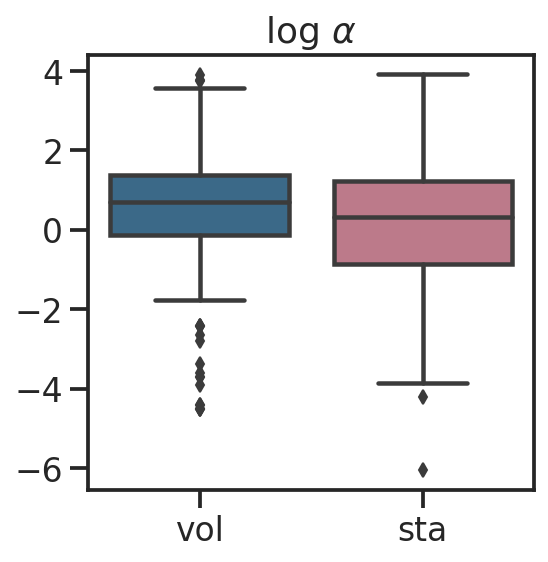

In [5]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))
for_title = t_test(pivot_table, 
            'b_type=="vol"', 'b_type=="sta"', 
            tar=['log_alpha'])
sns.boxplot(x='b_type', y='log_alpha', data=pivot_table,
                        palette=viz.Palette, ax=ax)
ax.set_title(r'log $\alpha$ '+f'{for_title[0]}')
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

### 1.4 the main effect 

l1 t-test: t=-1.3866, p-val:0.1666
l2 t-test: t=0.5845, p-val:0.5593
l3 t-test: t=-0.1872, p-val:0.8516
rational_deg t-test: t=-1.0491, p-val:0.2949


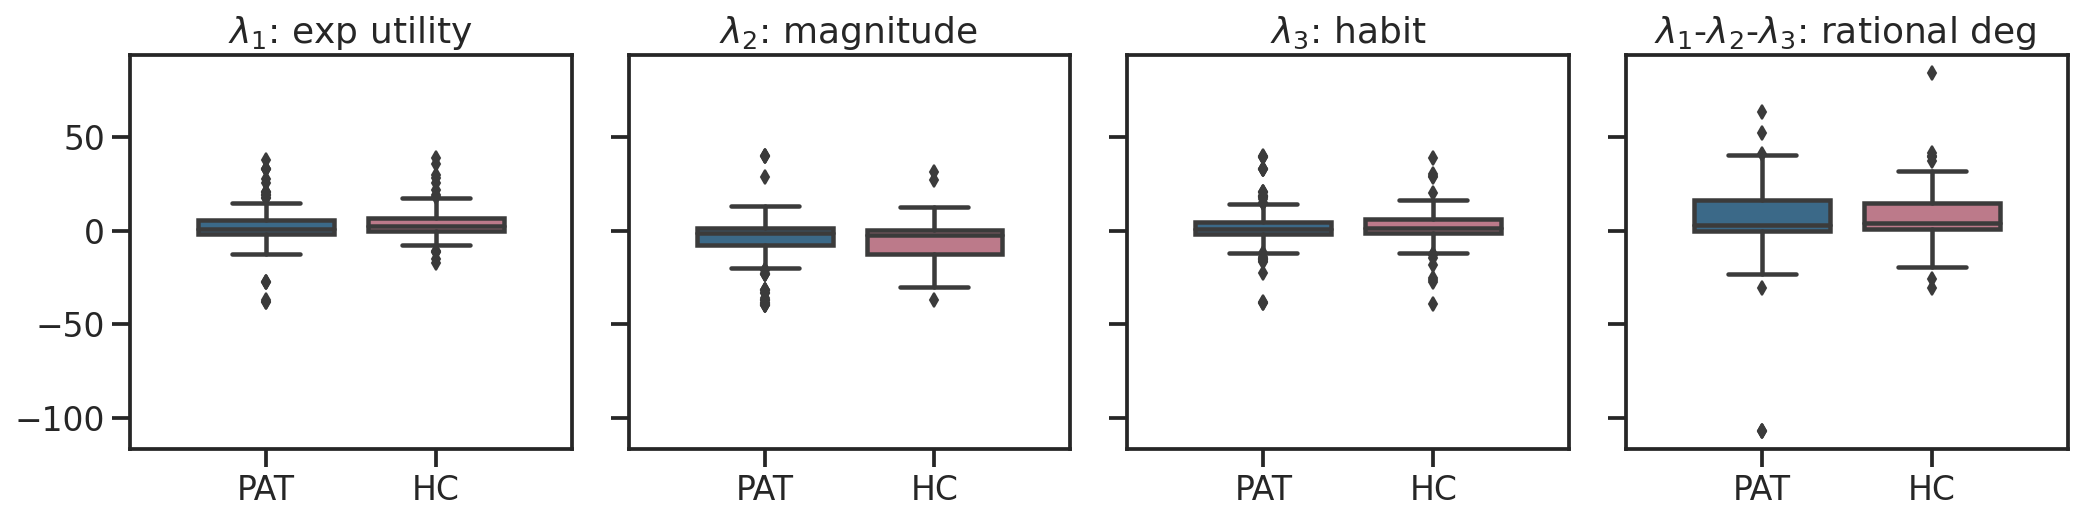

In [6]:
## Paitent V.S. healthy control 
main_effect(pivot_table, 
        pred='group', cond1='group!="HC"', cond2='group=="HC"', 
        tar=tars, notes=notes)

l1 t-test: t=-0.1245, p-val:0.9010
l2 t-test: t=0.2180, p-val:0.8276
l3 t-test: t=0.3272, p-val:0.7437
rational_deg t-test: t=-0.4167, p-val:0.6772


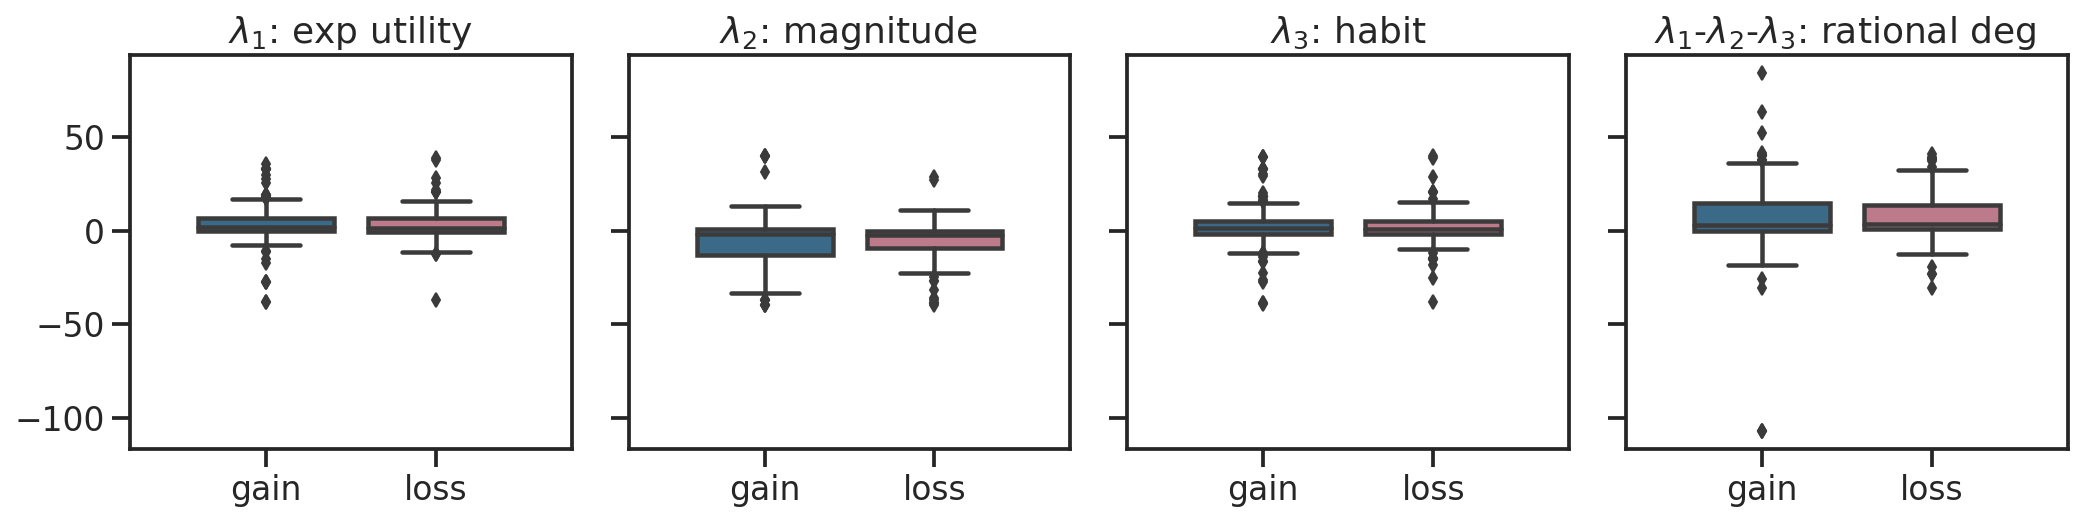

In [7]:
main_effect(pivot_table, 
        pred='feedback_type', cond1='feedback_type=="gain"', cond2='feedback_type=="loss"', 
        tar=tars, notes=notes)

l1 t-test: t=0.5939, p-val:0.5530
l2 t-test: t=1.2964, p-val:0.1958
l3 t-test: t=0.2586, p-val:0.7961
rational_deg t-test: t=-0.7403, p-val:0.4597


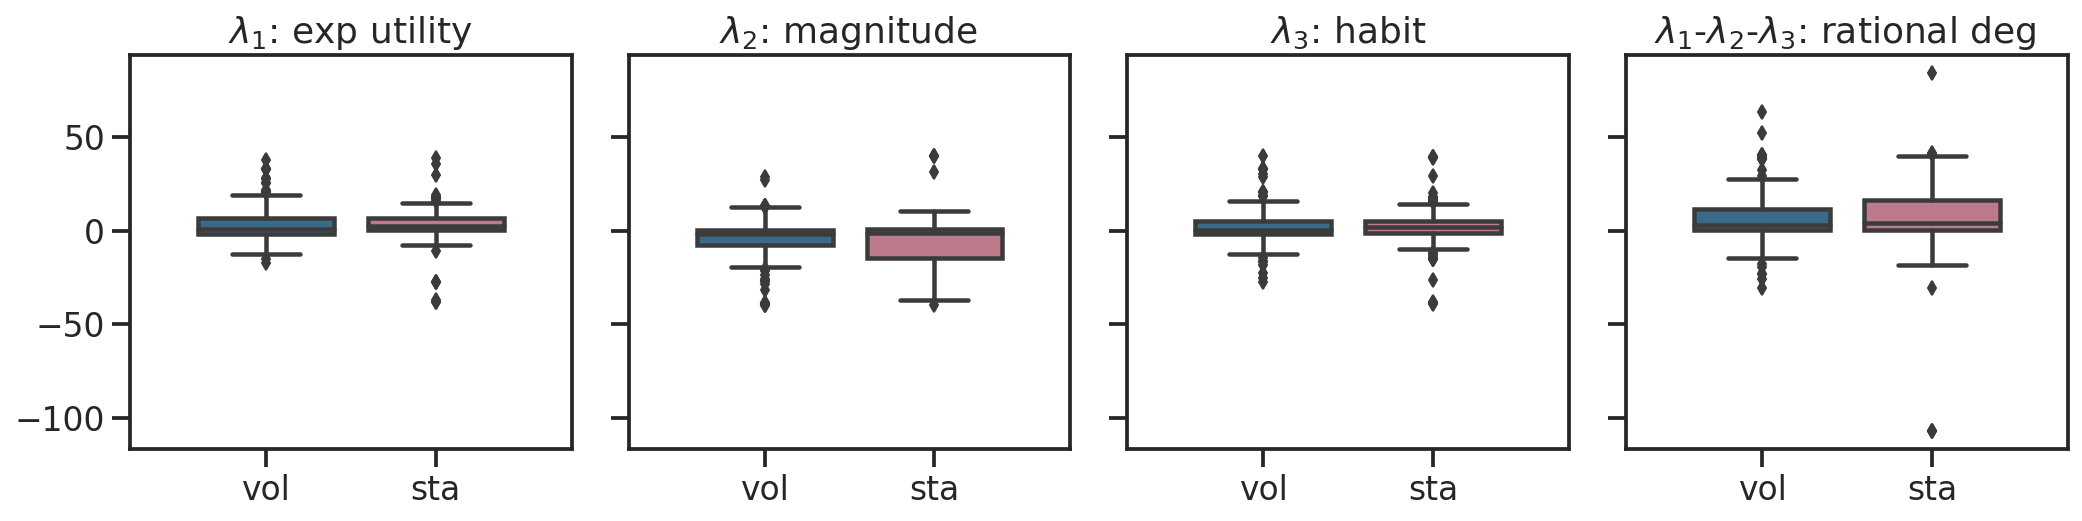

In [8]:
main_effect(pivot_table, 
        pred='b_type', cond1='b_type=="vol"', cond2='b_type=="sta"', 
        tar=tars, notes=notes)

### 1.5 the intersection effect 

l1 f-two way: f=12.2656, p-val:0.0005
l2 f-two way: f=0.5244, p-val:0.4695
l3 f-two way: f=3.8134, p-val:0.0517
rational_deg f-two way: f=1.4507, p-val:0.2293


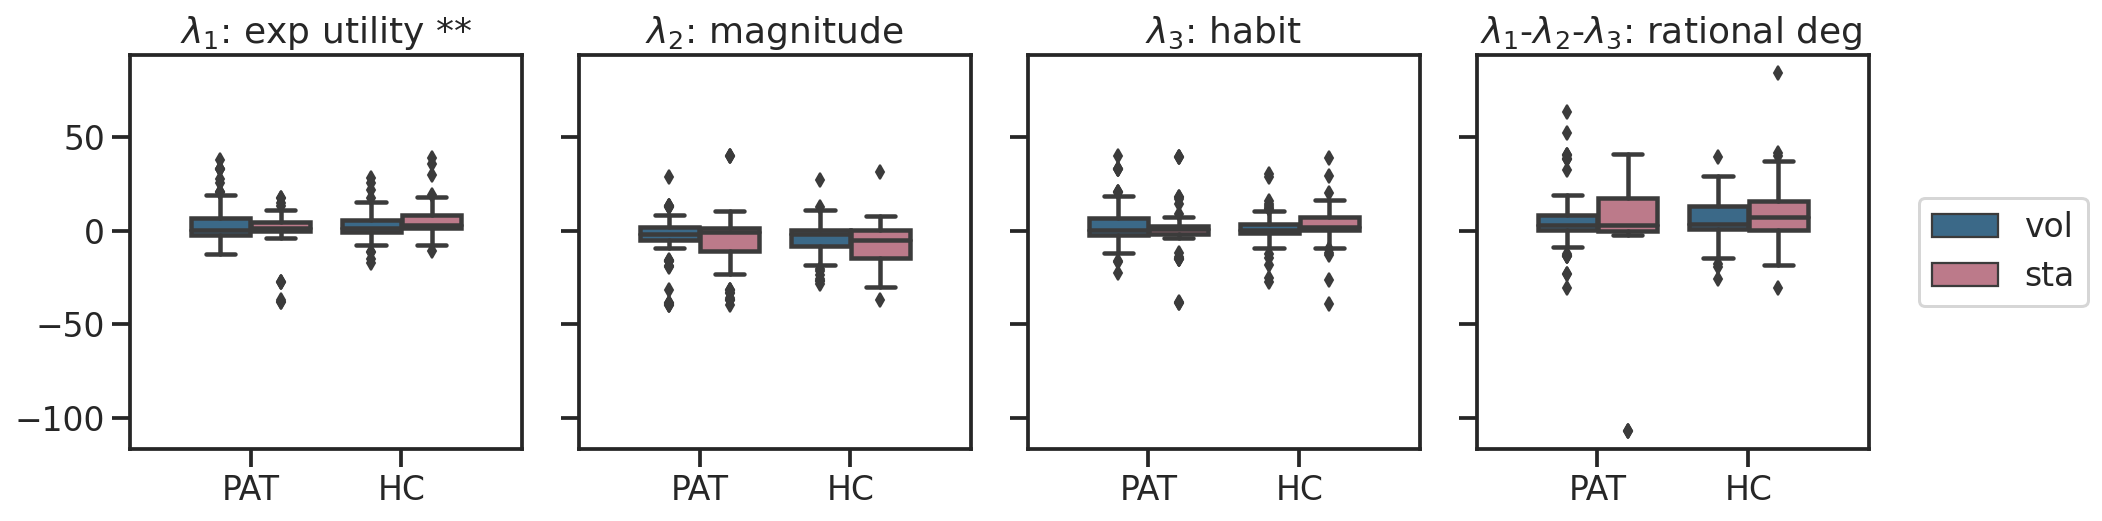

In [9]:
intersect_effect(pivot_table, 
        fac1='group', fac2='b_type',
        tar=tars, notes=notes,)

l1 f-two way: f=0.2675, p-val:0.6054
l2 f-two way: f=1.6016, p-val:0.2066
l3 f-two way: f=1.4789, p-val:0.2249
rational_deg f-two way: f=0.1915, p-val:0.6620


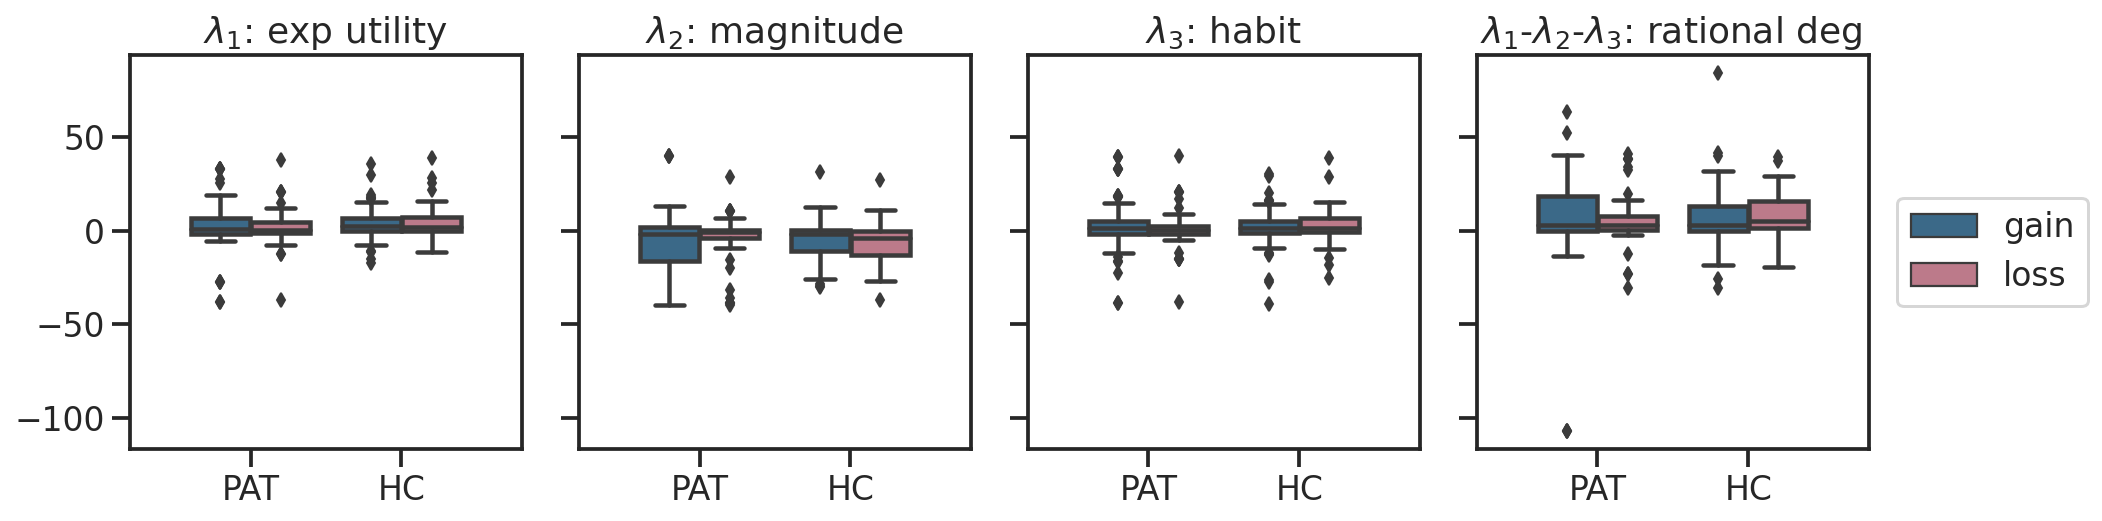

In [10]:
intersect_effect(pivot_table, 
        fac1='group', fac2='feedback_type',
        tar=tars, notes=notes)

### 1.6 predict the syndrome

g: r=-0.0581, pval=0.3055
f1: r=-0.0199, pval=0.7259
f2: r=0.0275, pval=0.6273


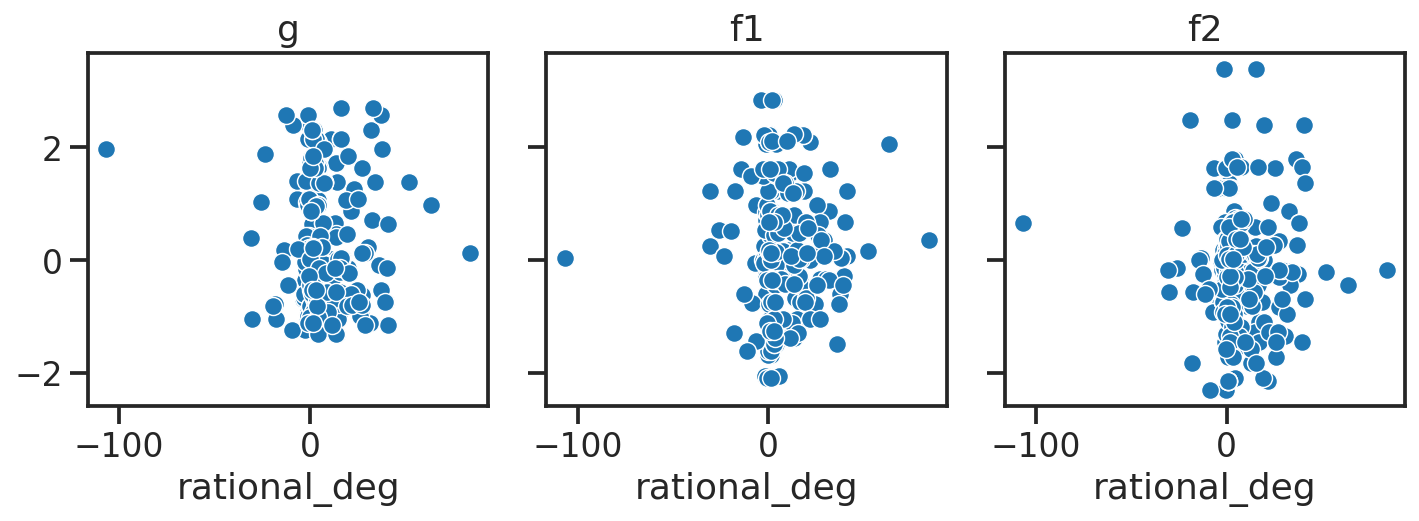

In [11]:
pred_syndrome(pivot_table, pred='rational_deg')

## 1. The MLE fit 

### 1. The priors

For variables $\alpha_\text{sta}$, $\alpha_\text{vol}$, $\beta$, $\alpha_\text{act}$ which have range (0, 50), we use Gamma priors: Gamma(3,.33)

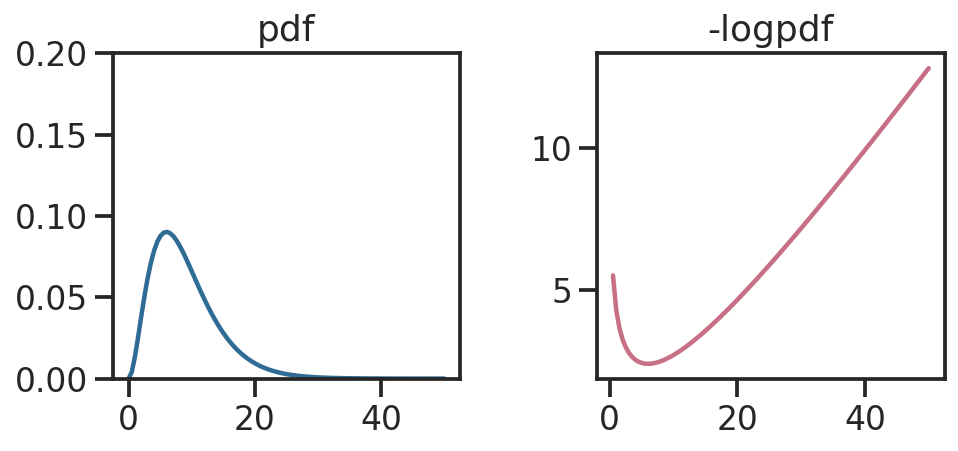

In [12]:
x = np.linspace(0, 50, 100)
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))
prior = gamma(a=3, scale=3)
ax = axs[0]
sns.lineplot(x=x, y=prior.pdf(x), color=viz.Blue, ax=ax)
ax.set_title('pdf')
ax.set_ylim([0, .2])
ax = axs[1]
sns.lineplot(x=x, y=-prior.logpdf(x), color=viz.Red, ax=ax)
ax.set_title('-logpdf')
plt.tight_layout()

For variables $\lambda_\text{1, sta}$, $\lambda_\text{1, vol}$, $\lambda_\text{2, sta}$, $\lambda_\text{2, vol}$, $\lambda_\text{3, sta}$, $\lambda_\text{3, vol}$ which have range (-40, 40), we use Gamma priors: N(0, 15)

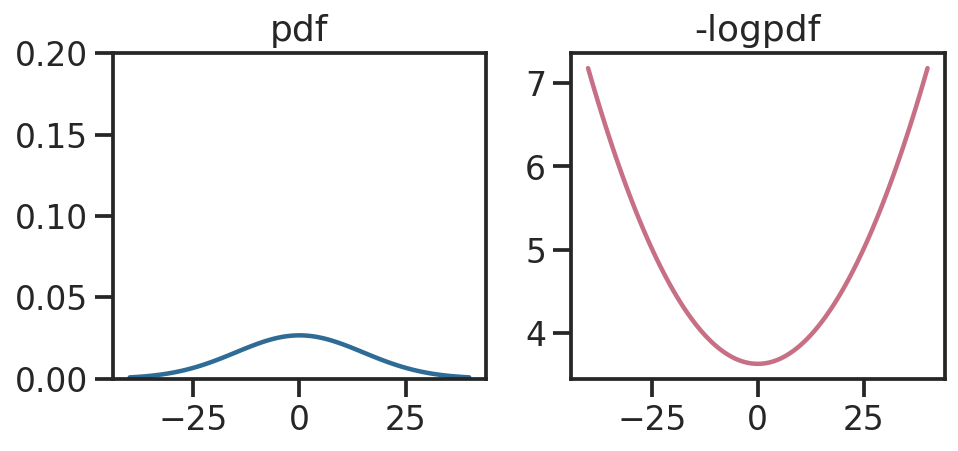

In [13]:
x = np.linspace(-40, 40, 100)
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))
prior = norm(loc=0, scale=15)
ax = axs[0]
sns.lineplot(x=x, y=prior.pdf(x), color=viz.Blue, ax=ax)
ax.set_title('pdf')
ax.set_ylim([0, .2])
ax = axs[1]
sns.lineplot(x=x, y=-prior.logpdf(x), color=viz.Red, ax=ax)
ax.set_title('-logpdf')
plt.tight_layout()

### 1.2 The model comparison

**The new model fit equally well with the other two published alternatives**


In [14]:
model_cmp(model_fit(['mix_pol_3w', 'gagModel', 'risk'], method='map'))


            ------------- nll ------------- 

            gagModel-risk: 
                gagModel:89.508, risk:86.478
                t=0.616 p=0.538

            gagModel-mix_pol_3w: 
                gagModel:89.508, mix_pol_3w:82.917
                t=1.346 p=0.180

            risk-mix_pol_3w: 
                risk:86.478, mix_pol_3w:82.917
                t=0.712 p=0.477

            ------------- aic ------------- 

            gagModel-risk: 
                gagModel:197.016, risk:182.957
                t=1.430 p=0.154

            gagModel-mix_pol_3w: 
                gagModel:197.016, mix_pol_3w:185.834
                t=1.142 p=0.255

            risk-mix_pol_3w: 
                risk:182.957, mix_pol_3w:185.834
                t=-0.288 p=0.774


In [15]:
tars =  ['l1', 'l2', 'l3'] 
notes    =  [r'$\lambda_1$: exp utility', r'$\lambda_2$: magnitude', r'$\lambda_3$: habit']
pivot_table = build_pivot_table(method='map', min_q=.01, max_q=.99)

#-------- Before Bootstrapping ---------- #

    #Total rows: 342

    #gain rows: 170
    #loss rows: 172

    #patient rows: 130
    #control rows: 212
    
    #patient x gain rows: 64
    #patient x loss rows: 66
    #control x gain rows: 106
    #control x loss rows: 106
    
#-------- After Bootstrapping ---------- #

    #Total rows: 424

    #gain rows: 212
    #loss rows: 212

    #patient rows: 212
    #control rows: 212
    
    #patient x gain rows: 106
    #patient x loss rows: 106
    #control x gain rows: 106
    #control x loss rows: 106
    
#-------- Clean Outliers ---------- #

    384 rows
    90.6% data has been retained


In [16]:
## feature engineering

# get rational degree: λ1 - λ2 - λ3
pivot_table['rational_deg'] = pivot_table.apply(lambda x: x['l1']-x['l2']-x['l3'], axis=1)
tars  += ['rational_deg']
notes += [r'$\lambda_1$-$\lambda_2$-$\lambda_3$: rational deg']

# the probability preference: λ1 - λ2
pivot_table['prob_per'] = pivot_table.apply(lambda x: x['l1']-x['l2'], axis=1)
tars  += ['prob_per']
notes += [r'$\lambda_1$-$\lambda_2$: prob per']

### 1.3 the learning rate 

log_alpha t-test: t=1.3166, p-val:0.1888


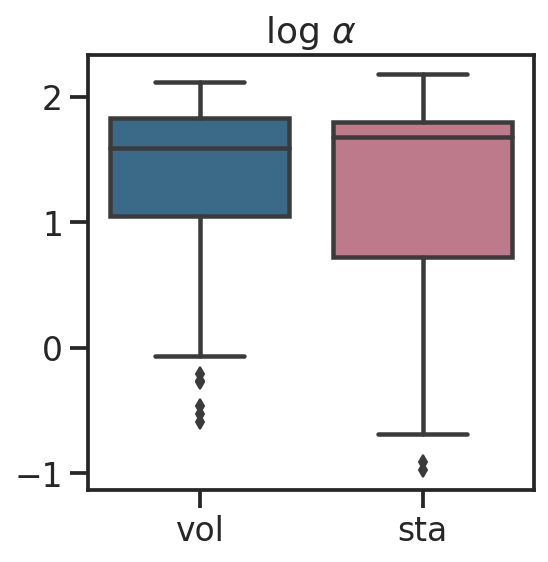

In [17]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))
for_title = t_test(pivot_table, 
            'b_type=="vol"', 'b_type=="sta"', 
            tar=['log_alpha'])
sns.boxplot(x='b_type', y='log_alpha', data=pivot_table,
                        palette=viz.Palette, ax=ax)
ax.set_title(r'log $\alpha$ '+f'{for_title[0]}')
ax.set_xlabel('')
ax.set_ylabel('')
plt.show()

### 1.4 the main effect

l1 t-test: t=-3.4947, p-val:0.0005
l2 t-test: t=5.4035, p-val:0.0000
l3 t-test: t=-3.8934, p-val:0.0001
rational_deg t-test: t=-3.4948, p-val:0.0005
prob_per t-test: t=-5.0437, p-val:0.0000


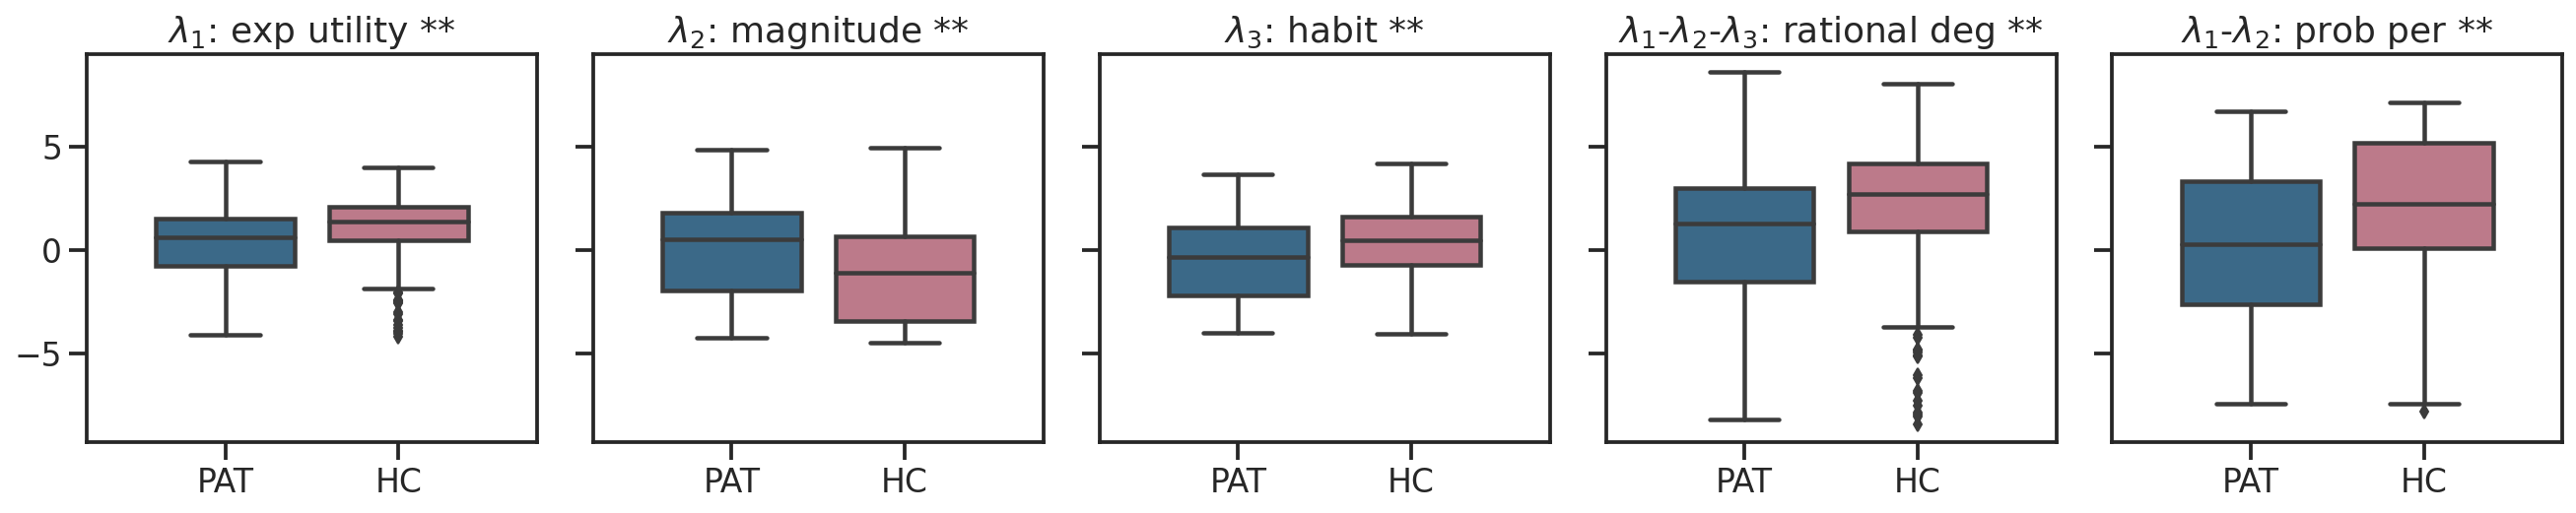

In [18]:
main_effect(pivot_table, 
        pred='group', cond1='group!="HC"', cond2='group=="HC"', 
        tar=tars, notes=notes)

l1 t-test: t=1.9088, p-val:0.0570
l2 t-test: t=-2.2725, p-val:0.0236
l3 t-test: t=1.2723, p-val:0.2040
rational_deg t-test: t=1.9092, p-val:0.0570
prob_per t-test: t=2.3153, p-val:0.0211


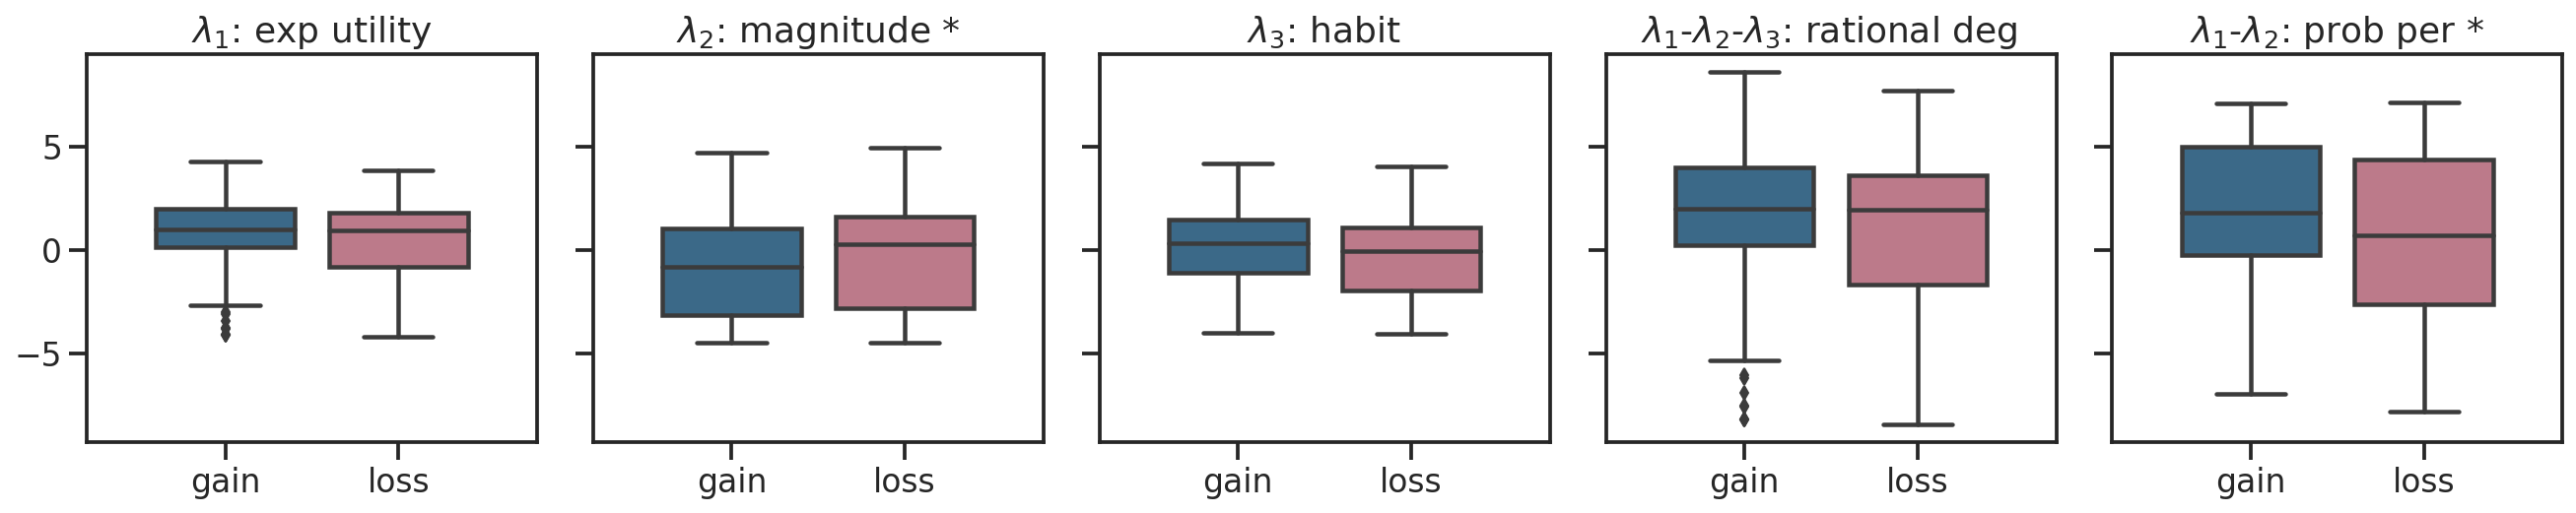

In [19]:
main_effect(pivot_table, 
        pred='feedback_type', cond1='feedback_type=="gain"', cond2='feedback_type=="loss"', 
        tar=tars, notes=notes)

l1 t-test: t=1.6421, p-val:0.1014
l2 t-test: t=-0.4373, p-val:0.6621
l3 t-test: t=-0.9489, p-val:0.3433
rational_deg t-test: t=1.6421, p-val:0.1014
prob_per t-test: t=1.0130, p-val:0.3117


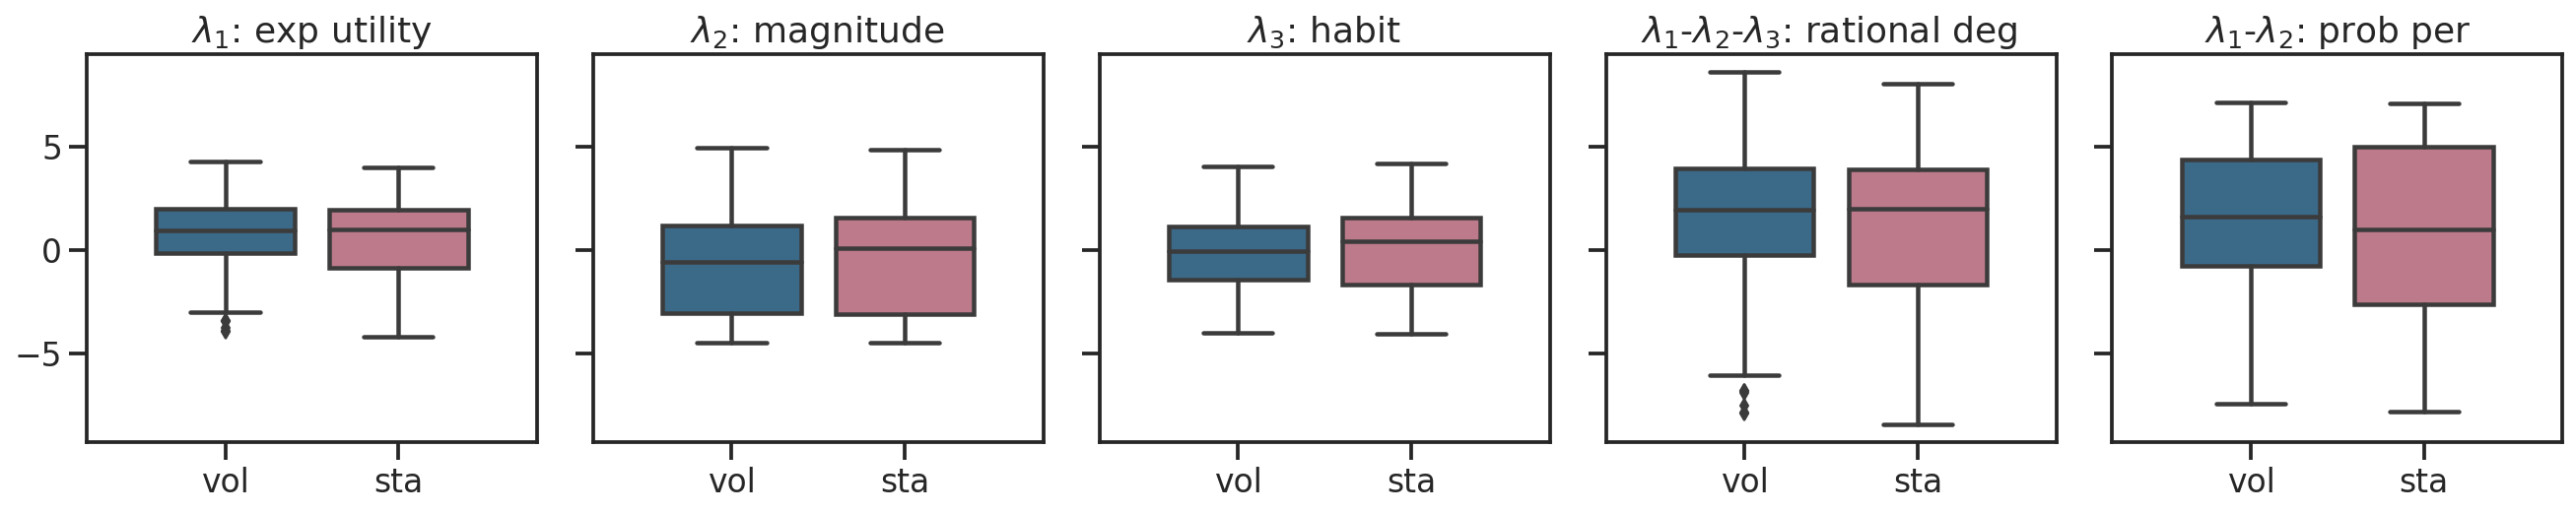

In [20]:
main_effect(pivot_table, 
        pred='b_type', cond1='b_type=="vol"', cond2='b_type=="sta"', 
        tar=tars, notes=notes)

### 1.5 the intersect effect

l1 f-two way: f=1.6995, p-val:0.1931
l2 f-two way: f=1.1148, p-val:0.2917
l3 f-two way: f=0.0326, p-val:0.8568
rational_deg f-two way: f=1.6981, p-val:0.1933
prob_per f-two way: f=1.6061, p-val:0.2058


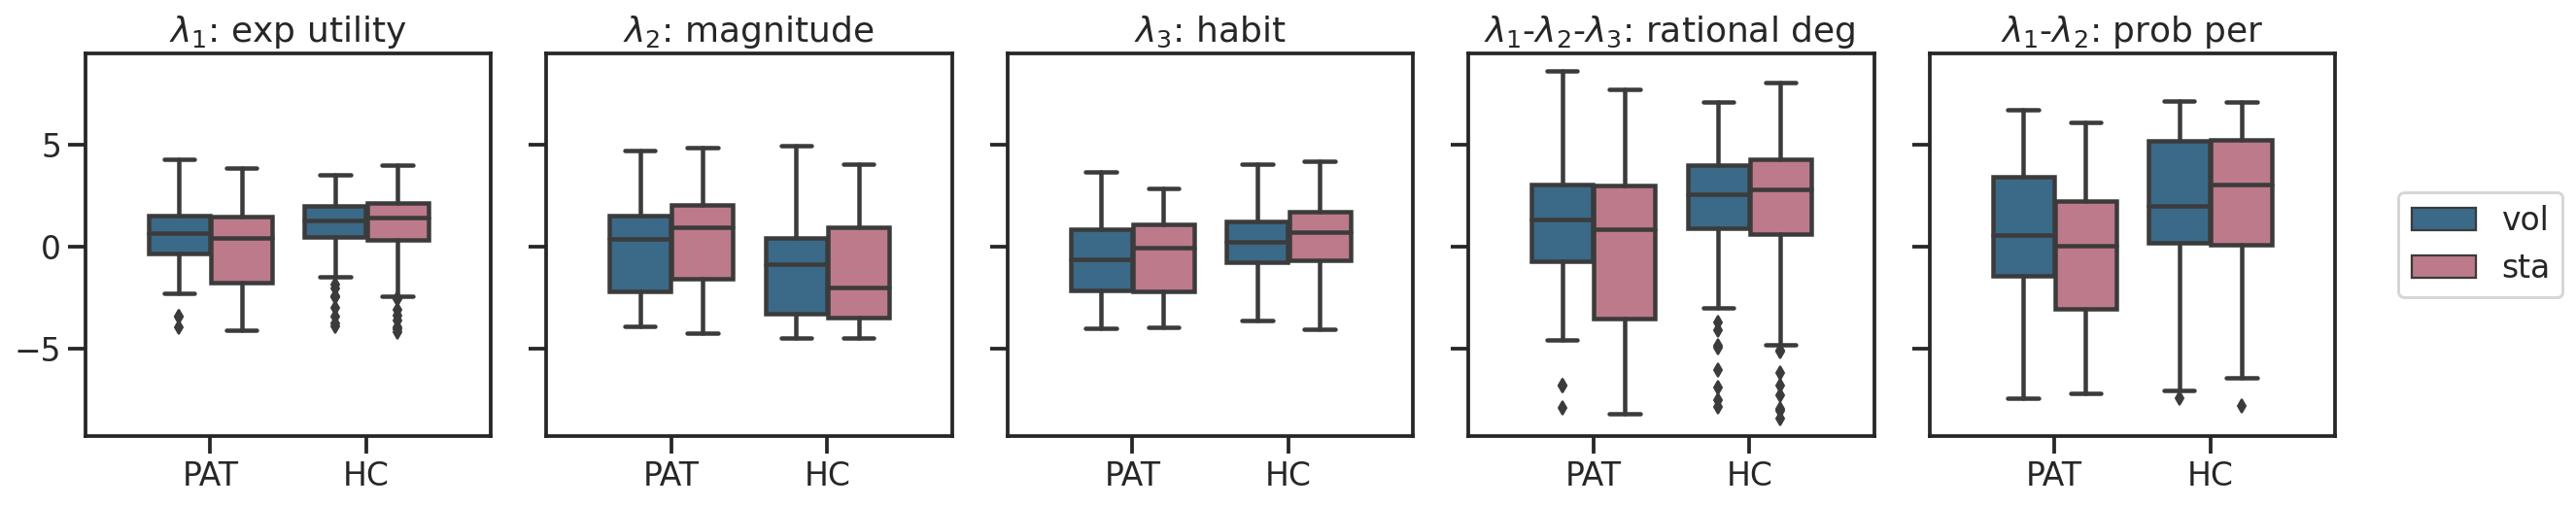

In [21]:
intersect_effect(pivot_table, 
        fac1='group', fac2='b_type',
        tar=tars, notes=notes,)

l1 f-two way: f=0.7461, p-val:0.3882
l2 f-two way: f=0.0320, p-val:0.8582
l3 f-two way: f=1.1060, p-val:0.2936
rational_deg f-two way: f=0.7461, p-val:0.3882
prob_per f-two way: f=0.0774, p-val:0.7811


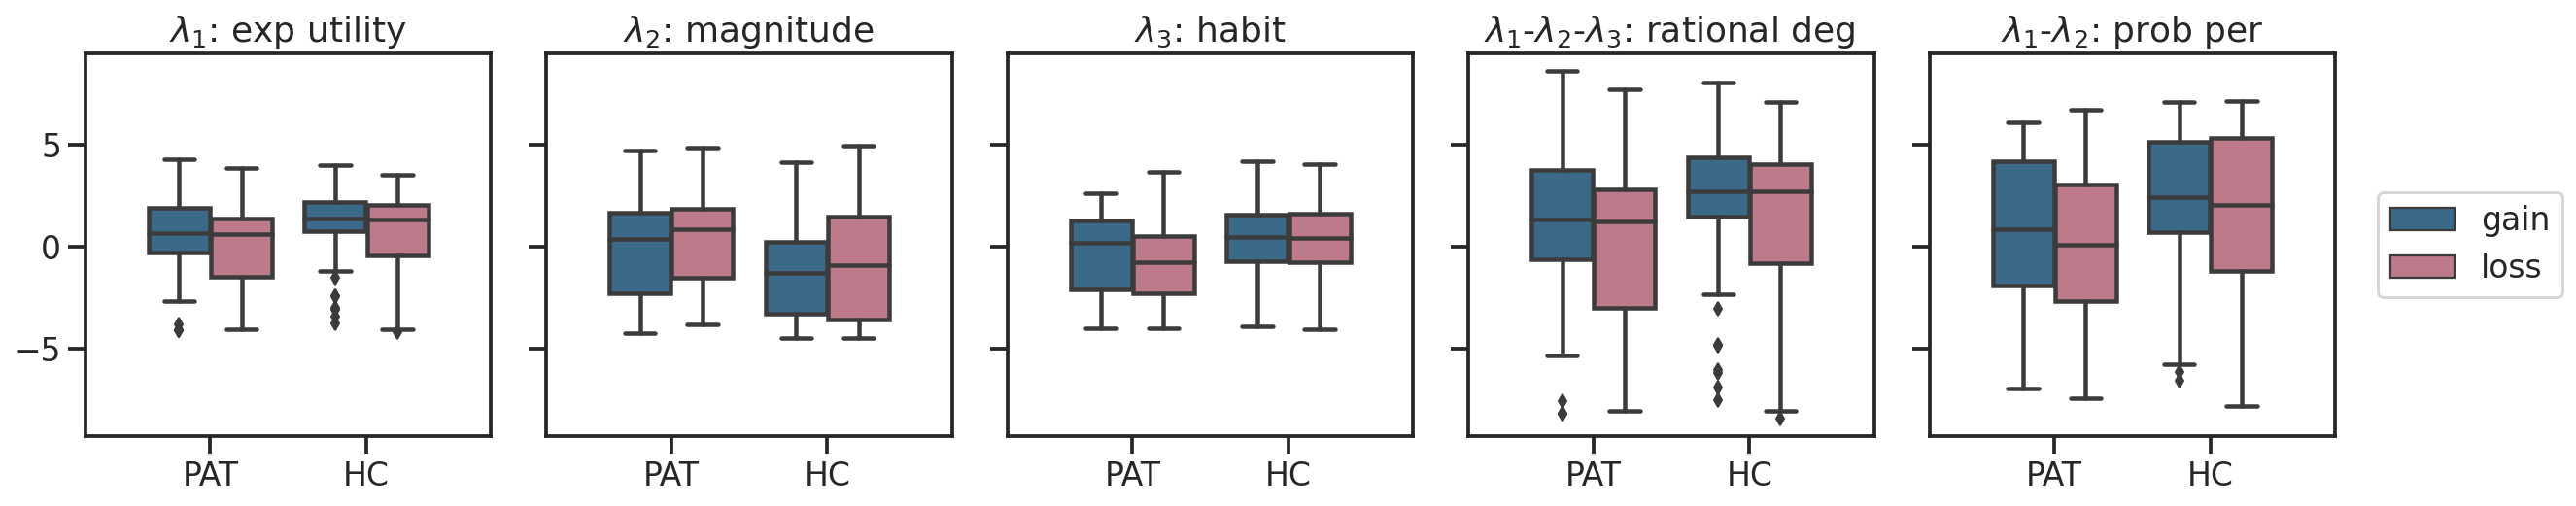

In [22]:
intersect_effect(pivot_table, 
        fac1='group', fac2='feedback_type',
        tar=tars, notes=notes,)

### 1.6 predict the syndrome 

g: r=-0.2316, pval=0.0000
f1: r=-0.0138, pval=0.7877
f2: r=-0.0467, pval=0.3610


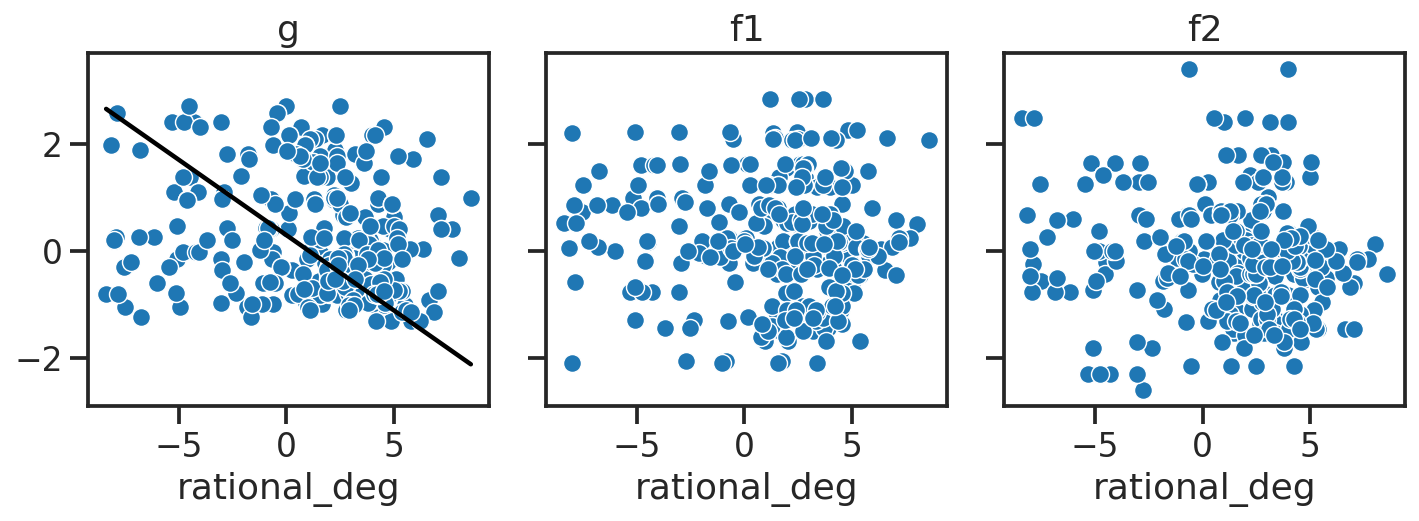

In [23]:
pred = 'rational_deg'
pred_syndrome(pivot_table, pred=pred)

g: r=-0.3258, pval=0.0000
f1: r=0.0219, pval=0.6689
f2: r=-0.0005, pval=0.9916


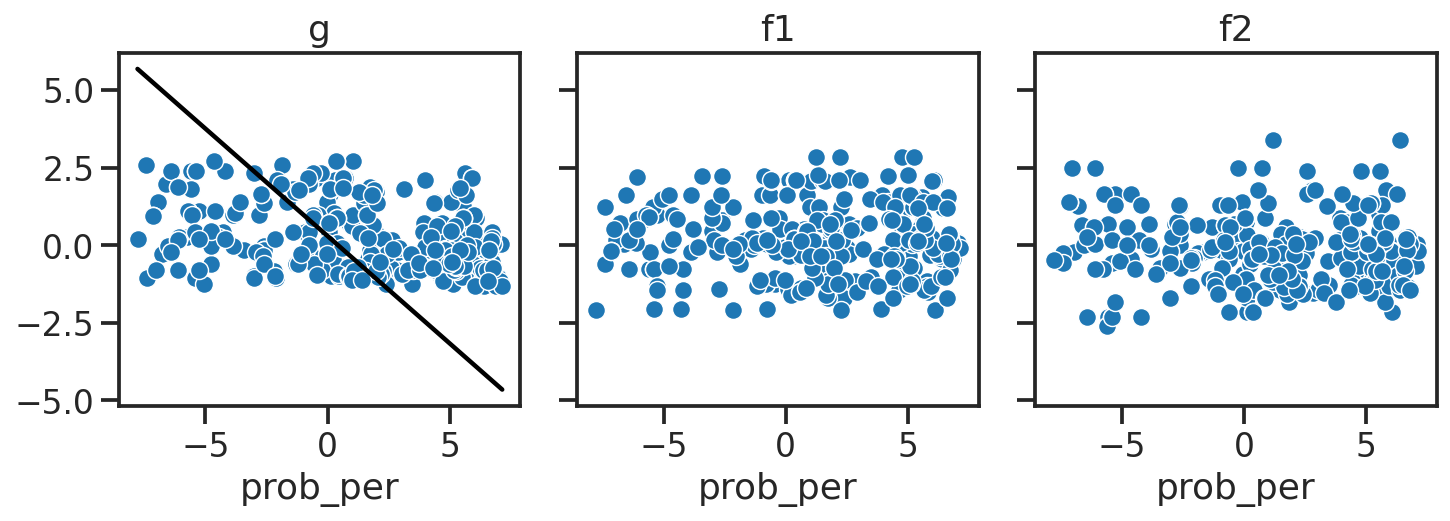

In [24]:
pred = 'prob_per'
pred_syndrome(pivot_table, pred=pred)